# Conditional variational autoencoder for prediction and feature recovery applied to intrusion detection in IoT

#### The purpose of a Network Intrusion Detection System is to detect intrusive, malicious activities or policy violations in a host or hosts network. In current networks, such a system is getting more important as the number and variety of attacks increase along with the volume and sensitiveness of the information exchanged. This is of particular interest to Internet of Things networks, where an intrusion detection system will be critical as its economic importance continues to grow, making it the focus of future intrusion attacks. In this work, we propose a new network intrusion detection method that is appropriate for an Internet of Things network. The proposed method is based on a Conditional Variational Autoencoder with a specific architecture that integrates the intrusion labels inside the decoder layers. The proposed method is less complex than other unsupervised methods based on a Variational Autoencoder and it provides better classification results than other familiar classifiers. More important, the method can perform feature reconstruction, that is, it is able to recover missing features from incomplete training datasets. We demonstrate that the reconstruction accuracy is very high, even for categorical features with a high number of distinct values. This work is unique in the network intrusion detection field, presenting the first application of a Conditional Variational Autoencoder and providing the first algorithm to perform feature recovery.

# 1. Prepare dataset
#### Load NSL-KDD dataset to perform training of the model and latter to assess its performance



In [1]:

# set working directory
import os
os.chdir("W:/UVA/InvestigacionUVA/Informe proyecto 2017/Codigo_papers/vae")

####################################################
# Load variables from previous session
####################################################
import dill
#dill.load_session('tf_NSL_KDD_Load.pkl')
load_from_pkl = True
if load_from_pkl:
    dill.load_session('tf_NSL_KDD20_Load_withWs.pkl')
    
os.chdir("W:/UVA/InvestigacionUVA/Informe proyecto 2017/Codigo_papers/cvae")
####################################################

In [3]:
import sklearn
sklearn.__version__

'0.18.1'

In [19]:
import lib
import sklearn
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
import pandas.core.algorithms as algos
from pandas import Series
from sklearn.preprocessing import OneHotEncoder



## 1.1 Create Training and Test datasets
#### Next we need to prepare the test and train data with one-hot encoding. We need to scale also the training data as NN is sensitive to data scaling

In [5]:
if not load_from_pkl:
    # create Y, matrix 
    YTrain = dataTrain['class']
    YTest = dataTest['class']


    # create X, matrix 
    XTest = dataTest.drop(['class','difficulty'], axis = 1)
    XTrain = dataTrain.drop(['class','difficulty'], axis = 1)
    lenXTrain = len(XTrain)
    lenXTest = len(XTest)

    # extract continous features
    XTrainContinous = dataTrain.drop(['class','difficulty','protocol_type', 'service','flag'], axis = 1)
    XTestContinous = dataTest.drop(['class','difficulty','protocol_type', 'service','flag'], axis = 1)

    # Eliminate columns which are mainly zeros
    t = XTrainContinous.apply(lambda x: sum(x != 0)) 
    minNumZeros = 100
    indexToErase = t[t<100].index
    XTrainContinous = XTrainContinous.drop(indexToErase, axis = 1)
    XTestContinous = XTestContinous.drop(indexToErase, axis = 1)

    # convert columns with continous data to categorical data, using a quantile over the values of each column.
    #XTrainContinousAsDis = XTrainContinous.apply(lambda x: pd.qcut(x, 20, labels=False))
    #XTestContinousAsDis = XTestContinous.apply(lambda x: pd.qcut(x, 20, labels=False))
    nBins = 40  # number of bins when doing the quantiles
    XTrainContinousAsDis = XTrainContinous.apply(lambda x: lib.helpFun2 (x, nBins)).astype(str)
    XTestContinousAsDis = XTestContinous.apply(lambda x: lib.helpFun2 (x, nBins)).astype(str)

    # extract discrete features
    XTrainDiscrete = dataTrain.loc[:,['protocol_type', 'service','flag']]
    XTestDiscrete = dataTest.loc[:,['protocol_type', 'service','flag']]

    # normalize the continous features

    # apply log(x+1) transform to features with great range
    tXTest = XTestContinous[['duration', 'src_bytes','dst_bytes','num_compromised',
    'num_root', 'count', 'srv_count', 'dst_host_count', 'dst_host_srv_count']]
    tXTrain = XTrainContinous[['duration', 'src_bytes','dst_bytes','num_compromised',
    'num_root', 'count', 'srv_count', 'dst_host_count', 'dst_host_srv_count']]

    XTestContinous[['duration', 'src_bytes','dst_bytes','num_compromised',
                    'num_root', 'count', 'srv_count', 'dst_host_count', 
                    'dst_host_srv_count']] = tXTest.apply(lambda x: np.log(x+1), 0)
    XTrainContinous[['duration', 'src_bytes','dst_bytes','num_compromised',
                     'num_root', 'count', 'srv_count', 'dst_host_count',
                     'dst_host_srv_count']] = tXTrain.apply(lambda x: np.log(x+1), 0)
    # and then apply an additional min-max or standard scaler to all the continous features
    scaler = MinMaxScaler()
    #scaler = StandardScaler()
    XTrainContinous = pd.DataFrame(scaler.fit_transform(XTrainContinous), columns=XTrainContinous.columns)
    XTestContinous = pd.DataFrame(scaler.fit_transform(XTestContinous), columns=XTestContinous.columns)


    # get back the full training data sets
    #XTrainAll =pd.concat([XTrainContinousAsDis,XTrainDiscrete], axis=1)
    #XTestAll =pd.concat([XTestContinousAsDis,XTestDiscrete], axis=1)
    XTrainAll =pd.concat([XTrainContinous,XTrainDiscrete], axis=1)
    XTestAll =pd.concat([XTestContinous,XTestDiscrete], axis=1)

    # one-hot encode the categorical features
    XAll = XTrainAll.append(XTestAll, ignore_index = True)
    #col_names = list(XAll.columns.values)
    col_names = ['protocol_type', 'service','flag']
    XAll, _, _= lib.one_hot_dataframe(XAll, col_names, replace=True)

    # extract XTrain and XTest
    XTrain = XAll.ix[:lenXTrain-1]
    XTest = XAll.ix[lenXTrain:]


    #convert to matrix
    XTrainM = XTrain.as_matrix()
    XTestM = XTest.as_matrix()

    # one hot encode Y and convert to matrix
    YTrainM = YTrain.as_matrix()
    YTestM = YTest.as_matrix()

    # for the VAE
    XTrainContinousM = XTrainContinous.as_matrix()
    XTestContinousM = XTestContinous.as_matrix()
    XAllDiscrete = XTrainDiscrete.append(XTestDiscrete, ignore_index = True)
    XAllDiscrete, _, _= lib.one_hot_dataframe(XAllDiscrete, col_names, replace=True)
    XAllDiscrete_flg = XAllDiscrete.ix[:,:11]
    XAllDiscrete_prot = XAllDiscrete.ix[:,11:14]
    XAllDiscrete_srv = XAllDiscrete.ix[:,14:]
    XTrainDiscreteM = XAllDiscrete.ix[:lenXTrain-1].as_matrix()
    XTestDiscreteM = XAllDiscrete.ix[lenXTrain:].as_matrix()
    XTrainDiscreteflgM = XAllDiscrete_flg.ix[:lenXTrain-1].as_matrix()
    XTestDiscreteflgM = XAllDiscrete_flg.ix[lenXTrain:].as_matrix()
    XTrainDiscreteprotM = XAllDiscrete_prot.ix[:lenXTrain-1].as_matrix()
    XTestDiscreteprotM = XAllDiscrete_prot.ix[lenXTrain:].as_matrix()
    XTrainDiscretesrvM = XAllDiscrete_srv.ix[:lenXTrain-1].as_matrix()
    XTestDiscretsrveM = XAllDiscrete_srv.ix[lenXTrain:].as_matrix()

    num_features = XTrainM.shape[1]

    YTestAN = YTest.apply(lambda x: 'normal' if x == 'normal' else 'anomaly')
    YTestANM = YTestAN.as_matrix()
    YTrainAN = YTrain.apply(lambda x: 'normal' if x == 'normal' else 'anomaly')
    YTrainANM = YTrainAN.as_matrix()
    YTestAN5 =YTest.apply(lambda x: 'NORMAL' if 'normal' in x else LabelToGroup[x])
    YTestAN5M = YTestAN5.as_matrix()
    YTrainAN5 = YTrain.apply(lambda x: 'NORMAL' if 'normal' in x else LabelToGroup[x])
    YTrainAN5M = YTrainAN5.as_matrix()

    # 23 labels
    lb = LabelBinarizer()
    lb.fit(YTrainM)
    #one-hot-encoded
    YTrainMOhe = lb.transform(YTrainM)
    YTestMOhe = lb.transform(YTestM) # this transformation changes YTest, as YTest has labels not present in YTrain

    # 5 labels
    lb5 = LabelBinarizer()
    lb5.fit(YTrainAN5M)
    #one-hot-encoded
    YTrainAN5MOhe = lb5.transform(YTrainAN5M)
    YTestAN5MOhe = lb5.transform(YTestAN5M) # this transformation changes YTest


    # 2 labels
    #one-hot-encoded
    YTrainANMOhe = np.array([[1,0] if x== 'normal' else [0,1] for x in YTrainANM])
    YTestANMOhe = np.array([[1,0] if x== 'normal' else [0,1] for x in YTestANM])



In [6]:
XTrainContinous.shape

(125973, 32)

## 1.2 Additional data preparation
### Additional data preparation needed to create additional features using the Non-negative Matrix Factorization algorithm. These features are not used in this project.

In [7]:
if not load_from_pkl:
    from sklearn.decomposition import NMF

    ## NMF
    # generate the W and H matrices for 23, 5 and components, and for Training and Testing

    nmf23 = NMF(n_components=23, init='nndsvdar', solver='cd', tol=0.0001, 
                max_iter=200, random_state=0, alpha=0.0, l1_ratio=0.0, 
                verbose=0, shuffle=False, nls_max_iter=2000)
    nmf23.fit(XTrainM) 
    W23Train = nmf23.transform(XTrainM)
    W23Test = nmf23.transform(XTestM)
    H23 =nmf23.components_


    nmf5 = NMF(n_components=5, init='nndsvdar', solver='cd', tol=0.0001, 
                max_iter=200, random_state=0, alpha=0.0, l1_ratio=0.0, 
                verbose=0, shuffle=False, nls_max_iter=2000)
    nmf5.fit(XTrainM) 
    W5Train = nmf5.transform(XTrainM)
    W5Test = nmf5.transform(XTestM)
    H5 =nmf5.components_


    nmf2 = NMF(n_components=2, init='nndsvdar', solver='cd', tol=0.0001, 
                max_iter=200, random_state=0, alpha=0.0, l1_ratio=0.0, 
                verbose=0, shuffle=False, nls_max_iter=2000)
    nmf2.fit(XTrainM) 
    W2Train = nmf2.transform(XTrainM)
    W2Test = nmf2.transform(XTestM)
    H2 =nmf2.components_

    nmf50 = NMF(n_components=50, init='nndsvdar', solver='cd', tol=0.0001, 
                max_iter=200, random_state=0, alpha=0.0, l1_ratio=0.0, 
                verbose=0, shuffle=False, nls_max_iter=2000)
    nmf50.fit(XTrainM) 
    W50Train = nmf50.transform(XTrainM)
    W50Test = nmf50.transform(XTestM)
    H50 =nmf50.components_

    from timeit import default_timer as timer
    start = timer()

    nmf75 = NMF(n_components=75, init='nndsvdar', solver='cd', tol=0.0001, 
                max_iter=200, random_state=0, alpha=0.0, l1_ratio=0.0, 
                verbose=0, shuffle=False, nls_max_iter=2000)
    nmf75.fit(XTrainM) 
    W75Train = nmf75.transform(XTrainM)
    W75Test = nmf75.transform(XTestM)
    H75 =nmf75.components_

    end = timer()
    print ("Time elapsed sec: {0}".format(end-start))

    from timeit import default_timer as timer
    start = timer()

    nmf100 = NMF(n_components=100, init='nndsvdar', solver='cd', tol=0.0001, 
                max_iter=200, random_state=0, alpha=0.0, l1_ratio=0.0, 
                verbose=0, shuffle=False, nls_max_iter=2000)
    nmf100.fit(XTrainM) 
    W100Train = nmf100.transform(XTrainM)
    W100Test = nmf100.transform(XTestM)
    H100 =nmf100.components_

    end = timer()
    print ("Time elapsed: {0}".format(end-start))

    # create W matrices with all componets concatenated
    WAllTrain = np.concatenate((W23Train,W5Train,W2Train), axis=1)
    WAllTest = np.concatenate((W23Test,W5Test,W2Test), axis=1)

    # create new training and testing matrices with the original data plus all components coming from W for 23, 5 and 2 components
    XTrainExten = np.concatenate((XTrainM, WAllTrain), axis=1)
    XTestExten = np.concatenate((XTestM, WAllTest), axis=1)

    # create new training and testing matrices with the original data plus the compoenent coming from W23
    XTrainW23 = np.concatenate((XTrainM, W23Train), axis=1)
    XTestW23 = np.concatenate((XTestM, W23Test), axis=1)

    # create new training and testing matrices with the original data plus the compoenent coming from W23
    XTrainW5 = np.concatenate((XTrainM, W5Train), axis=1)
    XTestW5 = np.concatenate((XTestM, W5Test), axis=1)

    # create new training and testing matrices with the original data plus the compoenent coming from W23
    XTrainW2 = np.concatenate((XTrainM, W2Train), axis=1)
    XTestW2 = np.concatenate((XTestM, W2Test), axis=1)

### Datasets sizes

In [8]:
print(XTrainM.shape,YTrainMOhe.shape, XTestM.shape, YTestMOhe.shape, YTestM.shape)

(125973, 116) (125973, 23) (22544, 116) (22544, 23) (22544,)


## 1.3 Support functions
### Additional functions. These functions are support functions that will be used latter.

In [9]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

def accuracy(predictions, labels):
  return (np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))/ predictions.shape[0])

# given probability predictions return the one-hot encoded associated labels
def labelOHEncodedFromPrediction(predictions):
  return ((predictions == np.reshape(np.max(predictions, 1),(len(predictions),-1)))*1)

#transform back labels (one-hot encoded) to strings for the case of labels with 23 values
def invTransLabels(labels):
    return(lb.inverse_transform(labels))

#transform back labels (one-hot encoded) to strings for the case of labels with 5 values
def invTransLabels5labels(labels):
    return(lb5.inverse_transform(labels))

#transform back labels (one-hot encoded) to strings for the case of labels with 2 values
def invTransLabels2labels(labels):
    return(np.array([ 'normal' if (x== [1,0]).all() else 'anomaly' for x in labels]))

def tf_rmse(x, y):
  return (tf.sqrt(tf.reduce_mean(tf.reduce_sum(tf.square(tf.sub(x,y)),1))))


def rmse(x, y):
  return np.sqrt(np.mean((x-y)**2))

In [10]:
#aa=np.array([[0.8, 0.9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0.9, 0.6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])
#labelOHEncodedFromPrediction(aa)

## 1.4 Functions to create training batchs
#### This function creates a new training dataset each time it is called

In [11]:
import time
import os
import math
from sklearn.model_selection import StratifiedKFold

class BatchTrainGen(object):

    def __init__(self, X, batch_size =100):
        self.X = X
        self.batch_size = batch_size
        
    def gen_offsets(self, ini = 0):
        self.batch_num = int(self.X.shape[0] / self.batch_size)
        self.indices = np.roll(np.arange(self.X.shape[0]),-ini)
        
    def gen_offsets_random(self, ini = 0):
        self.batch_num = int(self.X.shape[0] / self.batch_size)
        self.indices = np.random.permutation(self.X.shape[0])

    def batch_num(self):
        return self.batch_num
    
    def next_batch(self):
        fold = self.indices[:self.batch_size]
        x_batch = self.X[fold,:]
        self.indices = np.roll(self.indices,-self.batch_size)
        return (x_batch, fold)


## 1.5 Create Keras and tensorflow sessions

In [12]:
import tensorflow as tf
from keras import backend as K
from keras.layers import Dense
from keras.layers import Dropout
import keras

# attach keras and tensorflow
sess = tf.InteractiveSession()
K.set_session(sess)

tf.set_random_seed(1)

Using TensorFlow backend.


## 1.6 Functions to create different models

In [74]:

def config_nn_1(num_hidden_vars, f_activation = 'relu'):
    x_ini = tf.placeholder(tf.float32, [None, input_dim], name='x_ini')
    labels = tf.placeholder(tf.float32, [None, labels_dim], name='y')
    
    k= 1  # dropout probability
    # Keras layers can be called on TensorFlow tensors:
    #LR = keras.layers.advanced_activations.LeakyReLU(alpha=0)
    
    # encoder
    xe = Dense(500, activation = f_activation)(x_ini)  # fully-connected layer 
    xe = Dropout(k)(xe)
    xe = Dense(500, activation = f_activation)(xe)
    xe = Dropout(k)(xe)
    
    #posterior distributions
    z_mu = Dense(num_hidden_vars, activation = 'linear')(xe)
    z_log_sigma = Dense(num_hidden_vars, activation = 'linear')(xe)
    # Sample epsilon
    epsilon = tf.random_normal(tf.shape(z_log_sigma), name='epsilon')
    # Sample from posterior
    z = z_mu + tf.exp(z_log_sigma) * epsilon
    
    # decoder
    xd = Dense(300, activation = f_activation)(z)  # fully-connected layer 
    xd1 = Dropout(k)(xd)
    labels_ext = tf.tile(labels, [1,40]) # repeat the true labels n times
    xd2 = tf.concat(1,[xd1,labels_ext]) # concatenate the true labels repeated n times with the signals coming from z
    xd3 = Dense(500, activation = f_activation)(xd2)
    xd4 = Dropout(k)(xd3)
    
    #posterior distributions
    #yhat = Dense(output_dim,activation='softmax')(xd)  # if you use keras: categorical_crossentropy, you have to use softmax
    yhat = Dense(output_dim, activation = 'sigmoid')(xd4)
    
    return {'x_ini': x_ini, 'yhat': yhat, 'labels': labels, 'z_mu': z_mu, 'z_log_sigma' : z_log_sigma, 'z' : z}

def config_nn_1c(num_hidden_vars, f_activation = 'relu'):
    x_ini = tf.placeholder(tf.float32, [None, input_dim], name='x_ini')
    labels = tf.placeholder(tf.float32, [None, labels_dim], name='y')
    
    k= 1  # dropout probability
    # Keras layers can be called on TensorFlow tensors:
    #LR = keras.layers.advanced_activations.LeakyReLU(alpha=0)
    
    # encoder
    xe = Dense(500, activation = f_activation)(x_ini)  # fully-connected layer 
    xe = Dropout(k)(xe)
    xe = Dense(500, activation = f_activation)(xe)
    xe = Dropout(k)(xe)
    xe = Dense(500, activation = f_activation)(xe)
    xe = Dropout(k)(xe)
    
    #posterior distributions
    z_mu = Dense(num_hidden_vars, activation = 'linear')(xe)
    z_log_sigma = Dense(num_hidden_vars, activation = 'linear')(xe)
    # Sample epsilon
    epsilon = tf.random_normal(tf.shape(z_log_sigma), name='epsilon')
    # Sample from posterior
    z = z_mu + tf.exp(z_log_sigma) * epsilon
    
    # decoder
    xd = Dense(495, activation = f_activation)(z)  # fully-connected layer 
    xd1 = Dropout(k)(xd)
    labels_ext = tf.tile(labels, [1,40]) # repeat the true labels n times
    xd2 = tf.concat([xd1,labels_ext],1) # concatenate the true labels repeated n times with the signals coming from z
    xd3 = Dense(500, activation = f_activation)(xd2)
    xd3 = Dropout(k)(xd3)
    xd3 = Dense(500, activation = f_activation)(xd3)
    xd4 = Dropout(k)(xd3)
    
    #posterior distributions
    #yhat = Dense(output_dim,activation='softmax')(xd)  # if you use keras: categorical_crossentropy, you have to use softmax
    yhat = Dense(output_dim, activation = 'sigmoid')(xd4)
    
    return {'x_ini': x_ini, 'yhat': yhat, 'labels': labels, 'z_mu': z_mu, 'z_log_sigma' : z_log_sigma, 'z' : z}

def config_nn_1c_a(num_hidden_vars, f_activation = 'relu'):
    x_ini = tf.placeholder(tf.float32, [None, input_dim], name='x_ini')
    labels = tf.placeholder(tf.float32, [None, labels_dim], name='y')
    
    k= 1  # dropout probability
    # Keras layers can be called on TensorFlow tensors:
    #LR = keras.layers.advanced_activations.LeakyReLU(alpha=0)
    
    # encoder
    xe = Dense(500, activation = f_activation)(x_ini)  # fully-connected layer 
    xe = Dropout(k)(xe)
    xe = Dense(500, activation = f_activation)(xe)
    xe = Dropout(k)(xe)
    xe = Dense(500, activation = f_activation)(xe)
    xe = Dropout(k)(xe)
    
    #posterior distributions
    z_mu = Dense(num_hidden_vars, activation = 'linear')(xe)
    z_log_sigma = Dense(num_hidden_vars, activation = 'linear')(xe)
    # Sample epsilon
    epsilon = tf.random_normal(tf.shape(z_log_sigma), name='epsilon')
    # Sample from posterior
    z = z_mu + tf.exp(z_log_sigma) * epsilon
    
    # decoder
    labels_ext = tf.tile(labels, [1,40]) # repeat the true labels n times
    xd2 = tf.concat([z,labels_ext],1) # concatenate the true labels repeated n times with the signals coming from z
    xd = Dense(500, activation = f_activation)(xd2)  # fully-connected layer 
    xd1 = Dropout(k)(xd)
    
    
    xd3 = Dense(500, activation = f_activation)(xd1)
    xd3 = Dropout(k)(xd3)
    xd3 = Dense(500, activation = f_activation)(xd3)
    xd4 = Dropout(k)(xd3)
    
    #posterior distributions
    #yhat = Dense(output_dim,activation='softmax')(xd)  # if you use keras: categorical_crossentropy, you have to use softmax
    yhat = Dense(output_dim, activation = 'sigmoid')(xd4)
    
    return {'x_ini': x_ini, 'yhat': yhat, 'labels': labels, 'z_mu': z_mu, 'z_log_sigma' : z_log_sigma, 'z' : z}

def config_nn_1c_b(num_hidden_vars, f_activation = 'relu'):
    x_ini = tf.placeholder(tf.float32, [None, input_dim], name='x_ini')
    labels = tf.placeholder(tf.float32, [None, labels_dim], name='y')
    
    k= 1  # dropout probability
    # Keras layers can be called on TensorFlow tensors:
    #LR = keras.layers.advanced_activations.LeakyReLU(alpha=0)
    
    # encoder
    xe = Dense(500, activation = f_activation)(x_ini)  # fully-connected layer 
    xe = Dropout(k)(xe)
    xe = Dense(500, activation = f_activation)(xe)
    xe = Dropout(k)(xe)
    xe = Dense(500, activation = f_activation)(xe)
    xe = Dropout(k)(xe)
    
    #posterior distributions
    z_mu = Dense(num_hidden_vars, activation = 'linear')(xe)
    z_log_sigma = Dense(num_hidden_vars, activation = 'linear')(xe)
    # Sample epsilon
    epsilon = tf.random_normal(tf.shape(z_log_sigma), name='epsilon')
    # Sample from posterior
    z = z_mu + tf.exp(z_log_sigma) * epsilon
    
    # decoder
    xd = Dense(500, activation = f_activation)(z)  # fully-connected layer 
    xd1 = Dropout(k)(xd)
    xd3 = Dense(495, activation = f_activation)(xd1)
    xd3 = Dropout(k)(xd3)
    labels_ext = tf.tile(labels, [1,40]) # repeat the true labels n times
    xd2 = tf.concat([xd3,labels_ext],1) # concatenate the true labels repeated n times with the signals coming from z
    xd2 = Dense(500, activation = f_activation)(xd2)
    xd4 = Dropout(k)(xd2)
    
    #posterior distributions
    #yhat = Dense(output_dim,activation='softmax')(xd)  # if you use keras: categorical_crossentropy, you have to use softmax
    yhat = Dense(output_dim, activation = 'sigmoid')(xd4)
    
    return {'x_ini': x_ini, 'yhat': yhat, 'labels': labels, 'z_mu': z_mu, 'z_log_sigma' : z_log_sigma, 'z' : z}

def config_nn_1b(num_hidden_vars, f_activation = 'relu'):
    x_ini = tf.placeholder(tf.float32, [None, input_dim], name='x_ini')
    k= 1  # dropout probability
    # Keras layers can be called on TensorFlow tensors:
    #LR = keras.layers.advanced_activations.LeakyReLU(alpha=0)
    
    # encoder
    xe = Dense(500, activation = f_activation)(x_ini)  # fully-connected layer 
    xe = Dropout(k)(xe)
    xe = Dense(500, activation = f_activation)(xe)
    xe = Dropout(k)(xe)
    
    #posterior distributions
    z_mu = Dense(num_hidden_vars, activation = 'linear')(xe)
    z_log_sigma = Dense(num_hidden_vars, activation = 'linear')(xe)
    # Sample epsilon
    epsilon = tf.random_normal(tf.shape(z_log_sigma), name='epsilon')
    # Sample from posterior
    z = z_mu + tf.exp(z_log_sigma) * epsilon
    
    # decoder
    xd = Dense(500, activation = f_activation)(z)  # fully-connected layer 
    xd = Dropout(k)(xd)
    xd = Dense(500, activation = f_activation)(xd)
    xd = Dropout(k)(xd)
    
    #posterior distributions
    #yhat = Dense(output_dim,activation='softmax')(xd)  # if you use keras: categorical_crossentropy, you have to use softmax
    yhat = Dense(output_dim, activation = 'linear')(xd)
    
    return {'x_ini': x_ini, 'yhat': yhat, 'z_mu': z_mu, 'z_log_sigma' : z_log_sigma, 'z' : z}


def config_nn_1d(num_hidden_vars, f_activation = 'relu'):
    x_ini = tf.placeholder(tf.float32, [None, input_dim], name='x_ini')
    labels = tf.placeholder(tf.float32, [None, labels_dim], name='y')
    
    k= 1  # dropout probability
    # Keras layers can be called on TensorFlow tensors:
    #LR = keras.layers.advanced_activations.LeakyReLU(alpha=0)
    
    # encoder
    xe = Dense(500, activation = f_activation)(x_ini)  # fully-connected layer 
    xe = Dropout(k)(xe)
    xe = Dense(500, activation = f_activation)(xe)
    xe = Dropout(k)(xe)
    
    #posterior distributions
    z_mu = Dense(num_hidden_vars, activation = 'linear')(xe)
    z_log_sigma = Dense(num_hidden_vars, activation = 'linear')(xe)
    # Sample epsilon
    epsilon = tf.random_normal(tf.shape(z_log_sigma), name='epsilon')
    # Sample from posterior
    z = z_mu + tf.exp(z_log_sigma) * epsilon
    
    # decoder
    xd = Dense(500-5*label_repeat, activation = f_activation)(z)  # fully-connected layer 
    xd1 = Dropout(k)(xd)
    labels_ext = tf.tile(labels, [1,label_repeat]) # repeat the true labels n times
    xd2 = tf.concat([xd1,labels_ext],1) # concatenate the true labels repeated n times with the signals coming from z
    xd3 = Dense(500, activation = f_activation)(xd2)
    xd4 = Dropout(k)(xd3)
    
    #posterior distributions
    #yhat = Dense(output_dim,activation='softmax')(xd)  # if you use keras: categorical_crossentropy, you have to use softmax
    yhat = Dense(output_dim, activation = 'sigmoid')(xd4)
    
    return {'x_ini': x_ini, 'yhat': yhat, 'labels': labels, 'z_mu': z_mu, 'z_log_sigma' : z_log_sigma, 'z' : z}


# 2. Model CVAE from the paper

## 2.1 Train the model

Epoch 0 |Step 0 | Loss: 80.194977| KLD: 0.2539200484752655| BCE: 79.941055| Train rmse: 0.489165| Test rmse: 0.448033
Epoch 0 |Step 50 | Loss: 12.055540| KLD: 0.033236660063266754| BCE: 12.022304| Train rmse: 0.147454| Test rmse: 0.178697
Epoch 0 |Step 100 | Loss: 12.475129| KLD: 0.37777847051620483| BCE: 12.097351| Train rmse: 0.146363| Test rmse: 0.170938
Epoch 0 |Step 150 | Loss: 10.288136| KLD: 1.0246336460113525| BCE: 9.263503| Train rmse: 0.120815| Test rmse: 0.150713
Epoch 0 |Step 200 | Loss: 10.101171| KLD: 1.3401051759719849| BCE: 8.761065| Train rmse: 0.112428| Test rmse: 0.139818
Epoch 0 |Step 250 | Loss: 10.003502| KLD: 1.6199909448623657| BCE: 8.383511| Train rmse: 0.108566| Test rmse: 0.137616
Epoch 0 |Step 300 | Loss: 9.725897| KLD: 1.6322135925292969| BCE: 8.093683| Train rmse: 0.107428| Test rmse: 0.134193
Epoch 0 |Step 350 | Loss: 8.835167| KLD: 1.5592460632324219| BCE: 7.275921| Train rmse: 0.097917| Test rmse: 0.131505
Epoch 0 |Step 400 | Loss: 8.704957| KLD: 1.3850

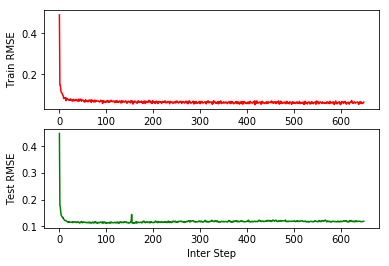

In [77]:
#tf.set_random_seed(123)
#np.random.seed(123)

from sklearn.metrics import mean_squared_error
from math import sqrt

# change as you change the input and output data
xtraining = XTrainM
xtesting =  XTestM
ytraining = XTrainM
ytesting =  XTestM

#input_dim = 116, out_dim = 23
input_dim = xtraining.shape[1]
output_dim = ytraining.shape[1]
labels_dim = 5
label_repeat = 1

#num_hidden_vars = 10
num_hidden_vars = 23
f_activation = 'relu'

#k = 1  # dropout probability
cnn = config_nn_1c(num_hidden_vars, f_activation)

y = tf.placeholder(tf.float32, [None, output_dim], name='y')

# p(x|z)
#log_px_given_z = tf.nn.sigmoid_cross_entropy_with_logits(cnn['yhat'],y)
log_px_given_z = -tf.reduce_sum(
    y * tf.log(cnn['yhat'] + 1e-10) +
    (1 - y) * tf.log(1 - cnn['yhat'] + 1e-10), 1)

# d_kl(q(z|x)||p(z))
kl_div = -0.5 * tf.reduce_sum(
    1.0 + 2.0 * cnn['z_log_sigma'] - tf.square(cnn['z_mu']) - tf.exp(2.0 * cnn['z_log_sigma']),
    1)

KLD = tf.reduce_mean(kl_div)
BCE = tf.reduce_mean(log_px_given_z)
#BCE = tf.sqrt(tf.reduce_mean(tf.reduce_sum(tf.square(tf.sub(y,yhat)),1)))
#BCE = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(cnn['yhat'], y)) 

loss = KLD + BCE 

learning_rate = 0.001
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

sess.run(tf.global_variables_initializer())

# Fit all training data
batch_size = 200
n_epochs = 50
print_step = 50


history = {'cost_h':[], 'train_rmse':[], 'test_rmse':[], 'kld':[], 'bce':[]}
for epoch in range(n_epochs):
    bt = BatchTrainGen(xtraining, batch_size)
    ini_offset = np.asscalar(np.random.randint(0,batch_size,1))
    bt.gen_offsets(ini_offset)
    # Loop over all batches
    for step in range(bt.batch_num):
        batch_xs, fold = bt.next_batch()
        batch_ys = ytraining[fold, :]
        batch_labels = YTrainAN5MOhe[fold, :]
        feed_dict = {cnn['labels']: batch_labels, cnn['x_ini']: batch_xs, y: batch_ys, K.learning_phase(): 1}
        cost, kld, bce, yhat, _ = sess.run([loss, KLD, BCE, cnn['yhat'], train_step], feed_dict = feed_dict)
        history['cost_h'].append(cost)

        if step % print_step == 0:
            batch_rmse = sqrt(mean_squared_error(batch_ys, yhat))
            test_rmse = sqrt(mean_squared_error(ytesting, 
                                                cnn['yhat'].eval(feed_dict={cnn['x_ini']: xtesting, 
                                                                            cnn['labels']: YTestAN5MOhe,
                                                                            K.learning_phase(): 0})))
            print("Epoch {0} |Step {1} | Loss: {2:.6f}| ".format(epoch,step,cost), end="")
            print("KLD: {0}| BCE: {1:.6f}| Train rmse: {2:.6f}| Test rmse: {3:.6f}".format(kld,
                                                                                           bce,
                                                                                           batch_rmse,
                                                                                           test_rmse))
            history['train_rmse'].append(batch_rmse)
            history['test_rmse'].append(test_rmse)
            history['kld'].append(kld)
            history['bce'].append(bce)


## Plot Loss
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history['cost_h'],'b-')
for xc in range(bt.batch_num,bt.batch_num*(n_epochs+1),bt.batch_num):
    plt.axvline(x=xc, color='r', linestyle='-')
plt.ylabel('Loss')
plt.xlabel('Step')
plt.show() 

## Plot kld and bce
plt.subplot(2, 1, 1)
plt.plot(history['bce'],'r-')
plt.ylabel('BCE')
plt.subplot(2, 1, 2)
plt.plot(history['kld'],'g-')
plt.ylabel('KLD')
plt.xlabel('Inter Step')
plt.show() 

## Plot Train Test rmse
plt.subplot(2, 1, 1)
plt.plot(history['train_rmse'],'r-')
plt.ylabel('Train RMSE')
plt.subplot(2, 1, 2)
plt.plot(history['test_rmse'],'g-')
plt.ylabel('Test RMSE')
plt.xlabel('Inter Step')
plt.show()   

## 2.2 Performance metrics-aggregated for label prediction
#### To perform the prediction we use the Test dataset

In [ ]:
## Label distribution

In [20]:
print('Counts')
print(YTestAN5.value_counts())
print('\nPercentage')
print(YTestAN5.value_counts().apply(lambda x: float(x)/sum(YTestAN5.value_counts()))*100)

Counts
NORMAL    9711
DOS       7458
R2L       2554
PROBE     2421
U2R        400
Name: class, dtype: int64

Percentage
NORMAL    43.075763
DOS       33.081973
R2L       11.328957
PROBE     10.738999
U2R        1.774308
Name: class, dtype: float64


In [96]:
def dist1(x,y):
    return (np.sqrt(np.mean(np.square(x-y),1)))
    
labels_names = np.array(['DOS', 'NORMAL', 'PROBE', 'R2L', 'U2R'])

# generamos matrices de labels iguales para hacer el test con una matriz de DOS, otra de R2L, etc...
labels_to_try = []
for n,i in enumerate(labels_names):
    labels_to_try.append(lb5.transform(np.array([i]*XTestM.shape[0])))

# forward pass con XtestM de entrada y 5 pasadas una por cada matrices de labels iguales
XTestM_hat_try = []
for n,i in enumerate(labels_names):
    XTestM_hat_try.append(cnn['yhat'].eval(feed_dict={cnn['x_ini']: xtesting, 
                                            cnn['labels']: labels_to_try[n], 
                                            K.learning_phase(): 0}))

#calculamos la minima distancia de cada resultado de los cinco pases con las matrices de labels iguales con la matriz original de features
distances = pd.DataFrame(index=range(XTestM.shape[0]))
for n,i in enumerate(np.array(['DOS', 'NORMAL', 'PROBE', 'R2L', 'U2R'])):
    distances[n] = dist1(XTestM,XTestM_hat_try[n])
    
# a partir de los indices sacamos los labels del resultado de la prediccion
YTestMhat=np.array([labels_names[i] for i in distances.idxmin(axis=1)])

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

print('\nPerformance measures. Test data')
print('Accuracy Test =  {}'.format(accuracy_score(YTestAN5M, YTestMhat)))
print('F1 =  {}'.format(f1_score(YTestAN5M, YTestMhat, average='weighted')))

print('Precision_score =  {}'.format(precision_score(YTestAN5M, YTestMhat, average='weighted')))

print('recall_score =  {}'.format(recall_score(YTestAN5M, YTestMhat, average='weighted')))

print('Confusion matrix:    Rows -> truth, Columns -> predictions')
confusionMat = pd.crosstab(YTestAN5M, YTestMhat, margins = True)
# marginals in percentage
confusionMat['Perc'] = [i/(0.5*sum(confusionMat['All'])) for i in confusionMat['All'] ]
confusionMat.ix[-1,-1] = 0
confusionMat.loc['Perc'] = [i/(0.5*sum(confusionMat.loc['All'])) for i in confusionMat.loc['All'] ]
confusionMat


Performance measures. Test data
Accuracy Test =  0.8009669978708304
F1 =  0.7907947155711857
Precision_score =  0.8159071115581659
recall_score =  0.8009669978708304
Confusion matrix:    Rows -> truth, Columns -> predictions


col_0           DOS        NORMAL        PROBE         R2L         U2R  \
row_0                                                                    
DOS     6351.000000    964.000000    62.000000   54.000000   27.000000   
NORMAL    86.000000   8925.000000   650.000000   26.000000   24.000000   
PROBE    309.000000    184.000000  1871.000000   24.000000   33.000000   
R2L        2.000000   1357.000000    22.000000  889.000000  284.000000   
U2R        2.000000    347.000000    24.000000    6.000000   21.000000   
All     6750.000000  11777.000000  2629.000000  999.000000  389.000000   
Perc       0.299414      0.522401     0.116616    0.044313    0.017255   

col_0       All      Perc  
row_0                      
DOS      7458.0  0.330820  
NORMAL   9711.0  0.430758  
PROBE    2421.0  0.107390  
R2L      2554.0  0.113290  
U2R       400.0  0.017743  
All     22544.0  0.000000  
Perc        1.0  0.000000

## 2.3 Performance metrics-one vs rest for label prediction
#### To perform the prediction we use the Test dataset

In [97]:
yt_app = YTestAN5.as_matrix()
perf_per_class = pd.DataFrame(index=range(len(YTestAN5.unique())),columns=['name', 'acc','f1', 'pre','rec'])
#perf_per_class = pd.DataFrame(index=range(len(y_test['APP'].unique())),columns=['name', 'acc'])
for i,x in enumerate(YTestAN5.value_counts().index):
    y_test_hat_check = YTestMhat.copy()
    y_test_hat_check[y_test_hat_check != x] = 'OTHER'
    yt_app = YTestAN5.as_matrix().copy()
    yt_app[yt_app != x] = 'OTHER'
    ac=accuracy_score( yt_app,y_test_hat_check)
    f1=f1_score( yt_app,y_test_hat_check,pos_label=x, average='binary')
    pr=precision_score( yt_app,y_test_hat_check,pos_label=x, average='binary')
    re=recall_score( yt_app,y_test_hat_check,pos_label=x, average='binary')
    perf_per_class.ix[i]=[x,ac,f1,pr,re]
# performance measures per class for test data
perf_per_class

name       acc         f1        pre       rec
0  NORMAL  0.838627   0.830696   0.757833  0.919061
1     DOS  0.933197   0.894003   0.940889  0.851569
2     R2L  0.921265   0.500422    0.88989  0.348081
3   PROBE   0.94198    0.74099   0.711677  0.772821
4     U2R  0.966865  0.0532319  0.0539846    0.0525

## 2.4 Results when the labels are applied in different places in the decoder

### 2.4.1 Apply the labels in the first layer of the decoder

### 2.4.1.1 Train the model

Epoch 0 |Step 0 | Loss: 81.039116| KLD: 0.24104340374469757| BCE: 80.798073| Train rmse: 0.493061| Test rmse: 0.455377
Epoch 0 |Step 50 | Loss: 12.073191| KLD: 0.09115444868803024| BCE: 11.982037| Train rmse: 0.146522| Test rmse: 0.178468
Epoch 0 |Step 100 | Loss: 12.401661| KLD: 0.7357771396636963| BCE: 11.665884| Train rmse: 0.141595| Test rmse: 0.156844
Epoch 0 |Step 150 | Loss: 10.171270| KLD: 1.2932758331298828| BCE: 8.877995| Train rmse: 0.112789| Test rmse: 0.148515
Epoch 0 |Step 200 | Loss: 10.080358| KLD: 1.2086390256881714| BCE: 8.871718| Train rmse: 0.113477| Test rmse: 0.139962
Epoch 0 |Step 250 | Loss: 9.530298| KLD: 1.4077932834625244| BCE: 8.122505| Train rmse: 0.106267| Test rmse: 0.133192
Epoch 0 |Step 300 | Loss: 8.691171| KLD: 1.5031787157058716| BCE: 7.187992| Train rmse: 0.093512| Test rmse: 0.131440
Epoch 0 |Step 350 | Loss: 8.920300| KLD: 1.5698705911636353| BCE: 7.350429| Train rmse: 0.097940| Test rmse: 0.130649
Epoch 0 |Step 400 | Loss: 8.274719| KLD: 1.584459

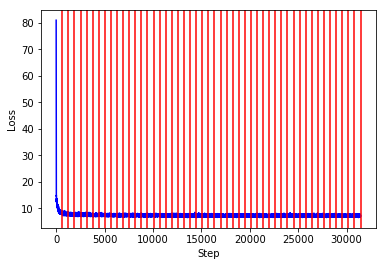

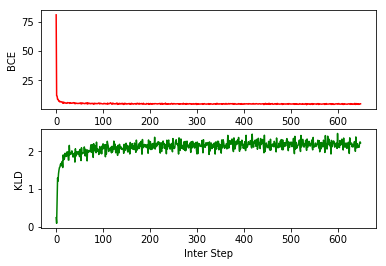

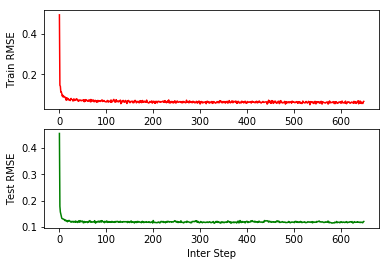

In [80]:
#tf.set_random_seed(123)
#np.random.seed(123)

from sklearn.metrics import mean_squared_error
from math import sqrt

# change as you change the input and output data
xtraining = XTrainM
xtesting =  XTestM
ytraining = XTrainM
ytesting =  XTestM

#input_dim = 116, out_dim = 23
input_dim = xtraining.shape[1]
output_dim = ytraining.shape[1]
labels_dim = 5
label_repeat = 1

#num_hidden_vars = 10
num_hidden_vars = 23
f_activation = 'relu'

#k = 1  # dropout probability
cnn = config_nn_1c_a(num_hidden_vars, f_activation)

y = tf.placeholder(tf.float32, [None, output_dim], name='y')

# p(x|z)
#log_px_given_z = tf.nn.sigmoid_cross_entropy_with_logits(cnn['yhat'],y)
log_px_given_z = -tf.reduce_sum(
    y * tf.log(cnn['yhat'] + 1e-10) +
    (1 - y) * tf.log(1 - cnn['yhat'] + 1e-10), 1)

# d_kl(q(z|x)||p(z))
kl_div = -0.5 * tf.reduce_sum(
    1.0 + 2.0 * cnn['z_log_sigma'] - tf.square(cnn['z_mu']) - tf.exp(2.0 * cnn['z_log_sigma']),
    1)

KLD = tf.reduce_mean(kl_div)
BCE = tf.reduce_mean(log_px_given_z)
#BCE = tf.sqrt(tf.reduce_mean(tf.reduce_sum(tf.square(tf.sub(y,yhat)),1)))
#BCE = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(cnn['yhat'], y)) 

loss = KLD + BCE 

learning_rate = 0.001
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

sess.run(tf.global_variables_initializer())

# Fit all training data
batch_size = 200
n_epochs = 50
print_step = 50


history = {'cost_h':[], 'train_rmse':[], 'test_rmse':[], 'kld':[], 'bce':[]}
for epoch in range(n_epochs):
    bt = BatchTrainGen(xtraining, batch_size)
    ini_offset = np.asscalar(np.random.randint(0,batch_size,1))
    bt.gen_offsets(ini_offset)
    # Loop over all batches
    for step in range(bt.batch_num):
        batch_xs, fold = bt.next_batch()
        batch_ys = ytraining[fold, :]
        batch_labels = YTrainAN5MOhe[fold, :]
        feed_dict = {cnn['labels']: batch_labels, cnn['x_ini']: batch_xs, y: batch_ys, K.learning_phase(): 1}
        cost, kld, bce, yhat, _ = sess.run([loss, KLD, BCE, cnn['yhat'], train_step], feed_dict = feed_dict)
        history['cost_h'].append(cost)

        if step % print_step == 0:
            batch_rmse = sqrt(mean_squared_error(batch_ys, yhat))
            test_rmse = sqrt(mean_squared_error(ytesting, 
                                                cnn['yhat'].eval(feed_dict={cnn['x_ini']: xtesting, 
                                                                            cnn['labels']: YTestAN5MOhe,
                                                                            K.learning_phase(): 0})))
            print("Epoch {0} |Step {1} | Loss: {2:.6f}| ".format(epoch,step,cost), end="")
            print("KLD: {0}| BCE: {1:.6f}| Train rmse: {2:.6f}| Test rmse: {3:.6f}".format(kld,
                                                                                           bce,
                                                                                           batch_rmse,
                                                                                           test_rmse))
            history['train_rmse'].append(batch_rmse)
            history['test_rmse'].append(test_rmse)
            history['kld'].append(kld)
            history['bce'].append(bce)


## Plot Loss
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history['cost_h'],'b-')
for xc in range(bt.batch_num,bt.batch_num*(n_epochs+1),bt.batch_num):
    plt.axvline(x=xc, color='r', linestyle='-')
plt.ylabel('Loss')
plt.xlabel('Step')
plt.show() 

## Plot kld and bce
plt.subplot(2, 1, 1)
plt.plot(history['bce'],'r-')
plt.ylabel('BCE')
plt.subplot(2, 1, 2)
plt.plot(history['kld'],'g-')
plt.ylabel('KLD')
plt.xlabel('Inter Step')
plt.show() 

## Plot Train Test rmse
plt.subplot(2, 1, 1)
plt.plot(history['train_rmse'],'r-')
plt.ylabel('Train RMSE')
plt.subplot(2, 1, 2)
plt.plot(history['test_rmse'],'g-')
plt.ylabel('Test RMSE')
plt.xlabel('Inter Step')
plt.show()   

### 2.4.1.2 Performance metrics-aggregated for label prediction
#### To perform the prediction we use the Test dataset

In [81]:
def dist1(x,y):
    return (np.sqrt(np.mean(np.square(x-y),1)))
    
labels_names = np.array(['DOS', 'NORMAL', 'PROBE', 'R2L', 'U2R'])

# generamos matrices de labels iguales para hacer el test con una matriz de DOS, otra de R2L, etc...
labels_to_try = []
for n,i in enumerate(labels_names):
    labels_to_try.append(lb5.transform(np.array([i]*XTestM.shape[0])))

# forward pass con XtestM de entrada y 5 pasadas una por cada matrices de labels iguales
XTestM_hat_try = []
for n,i in enumerate(labels_names):
    XTestM_hat_try.append(cnn['yhat'].eval(feed_dict={cnn['x_ini']: xtesting, 
                                            cnn['labels']: labels_to_try[n], 
                                            K.learning_phase(): 0}))

#calculamos la minima distancia de cada resultado de los cinco pases con las matrices de labels iguales con la matriz original de features
distances = pd.DataFrame(index=range(XTestM.shape[0]))
for n,i in enumerate(np.array(['DOS', 'NORMAL', 'PROBE', 'R2L', 'U2R'])):
    distances[n] = dist1(XTestM,XTestM_hat_try[n])
    
# a partir de los indices sacamos los labels del resultado de la prediccion
YTestMhat=np.array([labels_names[i] for i in distances.idxmin(axis=1)])

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

print('\nPerformance measures. Test data')
print('Accuracy Test =  {}'.format(accuracy_score(YTestAN5M, YTestMhat)))
print('F1 =  {}'.format(f1_score(YTestAN5M, YTestMhat, average='weighted')))

print('Precision_score =  {}'.format(precision_score(YTestAN5M, YTestMhat, average='weighted')))

print('recall_score =  {}'.format(recall_score(YTestAN5M, YTestMhat, average='weighted')))

print('Confusion matrix:    Rows -> truth, Columns -> predictions')
confusionMat = pd.crosstab(YTestAN5M, YTestMhat, margins = True)
# marginals in percentage
confusionMat['Perc'] = [i/(0.5*sum(confusionMat['All'])) for i in confusionMat['All'] ]
confusionMat.ix[-1,-1] = 0
confusionMat.loc['Perc'] = [i/(0.5*sum(confusionMat.loc['All'])) for i in confusionMat.loc['All'] ]
confusionMat


Performance measures. Test data
Accuracy Test =  0.7790986515259049
F1 =  0.7624667747299181
Precision_score =  0.7888049404135615
recall_score =  0.7790986515259049
Confusion matrix:    Rows -> truth, Columns -> predictions


col_0          DOS        NORMAL        PROBE         R2L         U2R  \
row_0                                                                   
DOS     6147.00000   1044.000000   115.000000   95.000000   57.000000   
NORMAL    81.00000   8912.000000   659.000000   34.000000   25.000000   
PROBE    288.00000    215.000000  1835.000000   23.000000   60.000000   
R2L      112.00000   1607.000000    32.000000  660.000000  143.000000   
U2R        4.00000    365.000000    13.000000    8.000000   10.000000   
All     6632.00000  12143.000000  2654.000000  820.000000  295.000000   
Perc       0.29418      0.538636     0.117725    0.036373    0.013086   

col_0       All      Perc  
row_0                      
DOS      7458.0  0.330820  
NORMAL   9711.0  0.430758  
PROBE    2421.0  0.107390  
R2L      2554.0  0.113290  
U2R       400.0  0.017743  
All     22544.0  0.000000  
Perc        1.0  0.000000

### 2.4.1.3 Performance metrics-one vs rest for label prediction
#### To perform the prediction we use the Test dataset

In [82]:
yt_app = YTestAN5.as_matrix()
perf_per_class = pd.DataFrame(index=range(len(YTestAN5.unique())),columns=['name', 'acc','f1', 'pre','rec'])
#perf_per_class = pd.DataFrame(index=range(len(y_test['APP'].unique())),columns=['name', 'acc'])
for i,x in enumerate(YTestAN5.value_counts().index):
    y_test_hat_check = YTestMhat.copy()
    y_test_hat_check[y_test_hat_check != x] = 'OTHER'
    yt_app = YTestAN5.as_matrix().copy()
    yt_app[yt_app != x] = 'OTHER'
    ac=accuracy_score( yt_app,y_test_hat_check)
    f1=f1_score( yt_app,y_test_hat_check,pos_label=x, average='binary')
    pr=precision_score( yt_app,y_test_hat_check,pos_label=x, average='binary')
    re=recall_score( yt_app,y_test_hat_check,pos_label=x, average='binary')
    perf_per_class.ix[i]=[x,ac,f1,pr,re]
# performance measures per class for test data
perf_per_class

name       acc        f1        pre       rec
0  NORMAL  0.821238  0.815594   0.733921  0.917722
1     DOS  0.920334  0.872534    0.92687  0.824216
2     R2L  0.908889  0.391227   0.804878  0.258418
3   PROBE  0.937677  0.723153   0.691409  0.757951
4     U2R  0.970059  0.028777  0.0338983     0.025

### 2.4.2  Apply the labels in the last layer of the decoder

### 2.4.2.1 Train the model

Epoch 0 |Step 0 | Loss: 82.348854| KLD: 0.2686862051486969| BCE: 82.080170| Train rmse: 0.498399| Test rmse: 0.460981
Epoch 0 |Step 50 | Loss: 12.110864| KLD: 0.037267960608005524| BCE: 12.073596| Train rmse: 0.147141| Test rmse: 0.179713
Epoch 0 |Step 100 | Loss: 12.867736| KLD: 0.13771045207977295| BCE: 12.730025| Train rmse: 0.150762| Test rmse: 0.180670
Epoch 0 |Step 150 | Loss: 10.436525| KLD: 0.7945886850357056| BCE: 9.641936| Train rmse: 0.122758| Test rmse: 0.155213
Epoch 0 |Step 200 | Loss: 10.820385| KLD: 1.1548867225646973| BCE: 9.665499| Train rmse: 0.121298| Test rmse: 0.143766
Epoch 0 |Step 250 | Loss: 9.302779| KLD: 1.5791642665863037| BCE: 7.723615| Train rmse: 0.101850| Test rmse: 0.136438
Epoch 0 |Step 300 | Loss: 9.578591| KLD: 1.4358012676239014| BCE: 8.142790| Train rmse: 0.104148| Test rmse: 0.135691
Epoch 0 |Step 350 | Loss: 8.986392| KLD: 1.5534313917160034| BCE: 7.432961| Train rmse: 0.098181| Test rmse: 0.129201
Epoch 0 |Step 400 | Loss: 8.702436| KLD: 1.78545

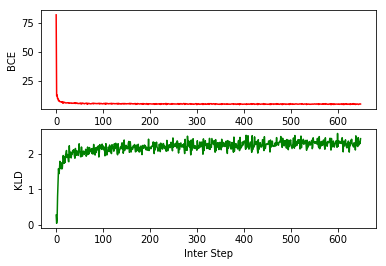

In [83]:
#tf.set_random_seed(123)
#np.random.seed(123)

from sklearn.metrics import mean_squared_error
from math import sqrt

# change as you change the input and output data
xtraining = XTrainM
xtesting =  XTestM
ytraining = XTrainM
ytesting =  XTestM

#input_dim = 116, out_dim = 23
input_dim = xtraining.shape[1]
output_dim = ytraining.shape[1]
labels_dim = 5
label_repeat = 1

#num_hidden_vars = 10
num_hidden_vars = 23
f_activation = 'relu'

#k = 1  # dropout probability
cnn = config_nn_1c_b(num_hidden_vars, f_activation)

y = tf.placeholder(tf.float32, [None, output_dim], name='y')

# p(x|z)
#log_px_given_z = tf.nn.sigmoid_cross_entropy_with_logits(cnn['yhat'],y)
log_px_given_z = -tf.reduce_sum(
    y * tf.log(cnn['yhat'] + 1e-10) +
    (1 - y) * tf.log(1 - cnn['yhat'] + 1e-10), 1)

# d_kl(q(z|x)||p(z))
kl_div = -0.5 * tf.reduce_sum(
    1.0 + 2.0 * cnn['z_log_sigma'] - tf.square(cnn['z_mu']) - tf.exp(2.0 * cnn['z_log_sigma']),
    1)

KLD = tf.reduce_mean(kl_div)
BCE = tf.reduce_mean(log_px_given_z)
#BCE = tf.sqrt(tf.reduce_mean(tf.reduce_sum(tf.square(tf.sub(y,yhat)),1)))
#BCE = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(cnn['yhat'], y)) 

loss = KLD + BCE 

learning_rate = 0.001
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

sess.run(tf.global_variables_initializer())

# Fit all training data
batch_size = 200
n_epochs = 50
print_step = 50


history = {'cost_h':[], 'train_rmse':[], 'test_rmse':[], 'kld':[], 'bce':[]}
for epoch in range(n_epochs):
    bt = BatchTrainGen(xtraining, batch_size)
    ini_offset = np.asscalar(np.random.randint(0,batch_size,1))
    bt.gen_offsets(ini_offset)
    # Loop over all batches
    for step in range(bt.batch_num):
        batch_xs, fold = bt.next_batch()
        batch_ys = ytraining[fold, :]
        batch_labels = YTrainAN5MOhe[fold, :]
        feed_dict = {cnn['labels']: batch_labels, cnn['x_ini']: batch_xs, y: batch_ys, K.learning_phase(): 1}
        cost, kld, bce, yhat, _ = sess.run([loss, KLD, BCE, cnn['yhat'], train_step], feed_dict = feed_dict)
        history['cost_h'].append(cost)

        if step % print_step == 0:
            batch_rmse = sqrt(mean_squared_error(batch_ys, yhat))
            test_rmse = sqrt(mean_squared_error(ytesting, 
                                                cnn['yhat'].eval(feed_dict={cnn['x_ini']: xtesting, 
                                                                            cnn['labels']: YTestAN5MOhe,
                                                                            K.learning_phase(): 0})))
            print("Epoch {0} |Step {1} | Loss: {2:.6f}| ".format(epoch,step,cost), end="")
            print("KLD: {0}| BCE: {1:.6f}| Train rmse: {2:.6f}| Test rmse: {3:.6f}".format(kld,
                                                                                           bce,
                                                                                           batch_rmse,
                                                                                           test_rmse))
            history['train_rmse'].append(batch_rmse)
            history['test_rmse'].append(test_rmse)
            history['kld'].append(kld)
            history['bce'].append(bce)


## Plot Loss
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history['cost_h'],'b-')
for xc in range(bt.batch_num,bt.batch_num*(n_epochs+1),bt.batch_num):
    plt.axvline(x=xc, color='r', linestyle='-')
plt.ylabel('Loss')
plt.xlabel('Step')
plt.show() 

## Plot kld and bce
plt.subplot(2, 1, 1)
plt.plot(history['bce'],'r-')
plt.ylabel('BCE')
plt.subplot(2, 1, 2)
plt.plot(history['kld'],'g-')
plt.ylabel('KLD')
plt.xlabel('Inter Step')
plt.show() 

## Plot Train Test rmse
plt.subplot(2, 1, 1)
plt.plot(history['train_rmse'],'r-')
plt.ylabel('Train RMSE')
plt.subplot(2, 1, 2)
plt.plot(history['test_rmse'],'g-')
plt.ylabel('Test RMSE')
plt.xlabel('Inter Step')
plt.show()   

### 2.4.2.2 Performance metrics-aggregated for label prediction
#### To perform the prediction we use the Test dataset

In [84]:
def dist1(x,y):
    return (np.sqrt(np.mean(np.square(x-y),1)))
    
labels_names = np.array(['DOS', 'NORMAL', 'PROBE', 'R2L', 'U2R'])

# generamos matrices de labels iguales para hacer el test con una matriz de DOS, otra de R2L, etc...
labels_to_try = []
for n,i in enumerate(labels_names):
    labels_to_try.append(lb5.transform(np.array([i]*XTestM.shape[0])))

# forward pass con XtestM de entrada y 5 pasadas una por cada matrices de labels iguales
XTestM_hat_try = []
for n,i in enumerate(labels_names):
    XTestM_hat_try.append(cnn['yhat'].eval(feed_dict={cnn['x_ini']: xtesting, 
                                            cnn['labels']: labels_to_try[n], 
                                            K.learning_phase(): 0}))

#calculamos la minima distancia de cada resultado de los cinco pases con las matrices de labels iguales con la matriz original de features
distances = pd.DataFrame(index=range(XTestM.shape[0]))
for n,i in enumerate(np.array(['DOS', 'NORMAL', 'PROBE', 'R2L', 'U2R'])):
    distances[n] = dist1(XTestM,XTestM_hat_try[n])
    
# a partir de los indices sacamos los labels del resultado de la prediccion
YTestMhat=np.array([labels_names[i] for i in distances.idxmin(axis=1)])

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

print('\nPerformance measures. Test data')
print('Accuracy Test =  {}'.format(accuracy_score(YTestAN5M, YTestMhat)))
print('F1 =  {}'.format(f1_score(YTestAN5M, YTestMhat, average='weighted')))

print('Precision_score =  {}'.format(precision_score(YTestAN5M, YTestMhat, average='weighted')))

print('recall_score =  {}'.format(recall_score(YTestAN5M, YTestMhat, average='weighted')))

print('Confusion matrix:    Rows -> truth, Columns -> predictions')
confusionMat = pd.crosstab(YTestAN5M, YTestMhat, margins = True)
# marginals in percentage
confusionMat['Perc'] = [i/(0.5*sum(confusionMat['All'])) for i in confusionMat['All'] ]
confusionMat.ix[-1,-1] = 0
confusionMat.loc['Perc'] = [i/(0.5*sum(confusionMat.loc['All'])) for i in confusionMat.loc['All'] ]
confusionMat


Performance measures. Test data
Accuracy Test =  0.7546575585521647
F1 =  0.7389094981772494
Precision_score =  0.7584350108735068
recall_score =  0.7546575585521647
Confusion matrix:    Rows -> truth, Columns -> predictions


col_0           DOS        NORMAL        PROBE         R2L         U2R  \
row_0                                                                    
DOS     5864.000000    889.000000   503.000000  157.000000   45.000000   
NORMAL   113.000000   8948.000000   569.000000   42.000000   39.000000   
PROBE    560.000000    272.000000  1506.000000   58.000000   25.000000   
R2L        4.000000   1676.000000    26.000000  668.000000  180.000000   
U2R        0.000000    361.000000     2.000000   10.000000   27.000000   
All     6541.000000  12146.000000  2606.000000  935.000000  316.000000   
Perc       0.290144      0.538769     0.115596    0.041474    0.014017   

col_0       All      Perc  
row_0                      
DOS      7458.0  0.330820  
NORMAL   9711.0  0.430758  
PROBE    2421.0  0.107390  
R2L      2554.0  0.113290  
U2R       400.0  0.017743  
All     22544.0  0.000000  
Perc        1.0  0.000000

### 2.4.2.3 Performance metrics-one vs rest for label prediction
#### To perform the prediction we use the Test dataset

In [85]:
yt_app = YTestAN5.as_matrix()
perf_per_class = pd.DataFrame(index=range(len(YTestAN5.unique())),columns=['name', 'acc','f1', 'pre','rec'])
#perf_per_class = pd.DataFrame(index=range(len(y_test['APP'].unique())),columns=['name', 'acc'])
for i,x in enumerate(YTestAN5.value_counts().index):
    y_test_hat_check = YTestMhat.copy()
    y_test_hat_check[y_test_hat_check != x] = 'OTHER'
    yt_app = YTestAN5.as_matrix().copy()
    yt_app[yt_app != x] = 'OTHER'
    ac=accuracy_score( yt_app,y_test_hat_check)
    f1=f1_score( yt_app,y_test_hat_check,pos_label=x, average='binary')
    pr=precision_score( yt_app,y_test_hat_check,pos_label=x, average='binary')
    re=recall_score( yt_app,y_test_hat_check,pos_label=x, average='binary')
    perf_per_class.ix[i]=[x,ac,f1,pr,re]
# performance measures per class for test data
perf_per_class

name       acc        f1       pre       rec
0  NORMAL  0.824299  0.818777  0.736703  0.921429
1     DOS  0.899264  0.837774  0.896499   0.78627
2     R2L  0.904498  0.382918  0.714439  0.261551
3   PROBE  0.910619  0.599165  0.577897  0.622057
4     U2R  0.970635  0.075419  0.085443    0.0675